In [1]:
#!/usr/bin/env python
# coding: utf-8

import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split
import hdf5storage
import torch.optim as optim
import math
import gc

In [2]:


# ##### 数据集预处理

class CSIFormerDataset(Dataset):
    
    def __init__(self, csi_ls, csi_pre, csi_label):
        """
        初始化数据集
        :param csi_ls: 导频CSI矩阵  [data_size, n_subc, n_sym, n_tx, n_rx, 2]
        :param csi: CSI矩阵 [data_size, n_subc, n_sym, n_tx, n_rx, 2]
        :param csi_pre: 历史CSI矩阵 [data_size, n_frame, n_subc, n_sym, n_tx, n_rx, 2]
        """
        self.csi_ls = csi_ls
        self.csi_pre = csi_pre
        self.csi_label = csi_label

    def __len__(self):
        """返回数据集大小"""
        return self.csi_label.size(0)

    def __getitem__(self, idx):
        """
        返回单个样本
        :param idx: 样本索引
        :return: 发射导频、接收导频、CSI矩阵
        """
        return self.csi_ls[idx], self.csi_pre[idx], self.csi_label[idx]

def dataset_preprocess(data):
    # 将数据转换为PyTorch张量
    csi_ls = torch.tensor(data['csiLSData'], dtype=torch.float32) #[data_size, n_subc, n_sym, n_tx, n_rx, 2]
    csi_pre = torch.tensor(data['csiPreData'], dtype=torch.float32) #[data_size, n_subc, n_sym, n_tx, n_rx, 2]
    csi_label = torch.tensor(data['csiLabelData'], dtype=torch.float32) #[data_size, n_subc, n_sym, n_tx, n_rx, 2]
    del data
    gc.collect()
    return CSIFormerDataset(csi_ls, csi_pre, csi_label)

###############################################################################
# 正弦/余弦位置编码
###############################################################################
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        """
        :param d_model: 嵌入特征的维度
        :param max_len: 序列的最大长度
        """
        super(PositionalEncoding, self).__init__()
        # 创建 [max_len, d_model] 的位置编码矩阵
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)  # [max_len, 1]
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)  # 偶数维度
        pe[:, 1::2] = torch.cos(position * div_term)  # 奇数维度
        pe = pe.unsqueeze(0)  # 增加 batch 维度
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        :param x: 输入张量 [B, seq_len, d_model]
        :return: 加入位置编码的张量 [B, seq_len, d_model]
        """
        seq_len = x.size(1)
        return x + self.pe[:, :seq_len, :]

###############################################################################
# 第一部分：CSIFormer (编码器)
###############################################################################
class CSIEncoder(nn.Module):
    def __init__(self, d_model=256, nhead=8, n_layers=6, n_tx=2, n_rx=2, max_len=5000):
        """
        编码器模块
        :param d_model: Transformer 嵌入维度
        :param nhead: 多头注意力头数
        :param n_layers: Transformer 层数
        :param n_tx: 发射天线数
        :param n_rx: 接收天线数
        :param max_len: 序列的最大长度
        """
        super(CSIEncoder, self).__init__()
        self.d_model = d_model
        self.num_tx = n_tx
        self.num_rx = n_rx

        # 线性层将输入映射到 d_model 维度
        self.input_proj = nn.Linear(n_tx * n_rx * 2, d_model)

        # 位置编码
        self.pos_encoder = PositionalEncoding(d_model, max_len)

        # Transformer 编码器
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=d_model,
                nhead=nhead,
                dim_feedforward=2048,
                batch_first=True
            ),
            num_layers=n_layers
        )

    def forward(self, csi_ls):
        """
        :param csi_ls: 当前帧的导频估计 [B, n_subc, n_sym, n_tx, n_rx, 2]
        :return: 编码后的特征 [B, seq_len, d_model]
        """
        B, n_subc, n_sym, n_tx, n_rx, _ = csi_ls.shape

        # 展平 CSI 矩阵并投影到 d_model
        csi_ls = csi_ls.view(B, n_subc, n_sym, -1)
        input_features = self.input_proj(csi_ls)  # [B, n_subc, n_sym, d_model]

        # 展平 (n_subc, n_sym) 维度为 seq_len
        input_features = input_features.view(B, n_subc * n_sym, self.d_model)

        # 添加位置编码
        input_features = self.pos_encoder(input_features)

        # Transformer 编码器
        output_features = self.transformer_encoder(input_features)
        return output_features

###############################################################################
# 第二部分：EnhancedCSIDecoder (解码器)
###############################################################################
class EnhancedCSIDecoder(nn.Module):
    def __init__(self, d_model=256, nhead=8, n_layers=6, n_tx=2, n_rx=2, max_len=5000):
        """
        :param d_model: Decoder 嵌入维度
        :param nhead: 注意力头数
        :param n_layers: 解码器层数
        :param n_tx: 发射天线数
        :param n_rx: 接收天线数
        :param max_len: 序列的最大长度
        """
        super(EnhancedCSIDecoder, self).__init__()
        self.d_model = d_model
        self.num_tx = n_tx
        self.num_rx = n_rx

        # Transformer 解码器 (batch_first=True)
        self.transformer_decoder = nn.TransformerDecoder(
            nn.TransformerDecoderLayer(
                d_model=d_model, 
                nhead=nhead,
                dim_feedforward=2048,
                batch_first=True
            ),
            num_layers=n_layers
        )

        # 位置编码
        self.pos_query = PositionalEncoding(d_model, max_len)
        self.pos_memory = PositionalEncoding(d_model, max_len)

        # 输出映射层，将 d_model 映射回原始 CSI 空间
        self.output_proj = nn.Linear(d_model, n_tx * n_rx * 2)

        # 投影历史 CSI 到 d_model 维度
        self.memory_proj = nn.Linear(n_tx * n_rx * 2, d_model)

    def forward(self, encoder_features, previous_csi):
        """
        :param encoder_features: 编码器的输出特征 [B, seq_len, d_model]
        :param previous_csi:    前 n 帧 CSI    [B, n_frame, n_subc, n_sym, n_tx, n_rx, 2]
        :return: 增强后的当前帧 CSI [B, n_subc, n_sym, n_tx, n_rx, 2]
        """
        B, seq_len, _ = encoder_features.shape
        _, n_frame, n_subc, n_sym, n_tx, n_rx, _ = previous_csi.shape
        # 添加 Query 的位置编码
        query = self.pos_query(encoder_features)
        # ============= 处理 Memory (previous_csi) =============
        # 展平历史 CSI 为 [B, n_frames, n_subc, n_sym, n_tx * n_rx * 2]
        memory = previous_csi.view(B, n_frame, n_subc, n_sym, -1)
        # 投影到 d_model 维度
        memory = self.memory_proj(memory)  # [B, n_frames, n_subc, n_sym, d_model]
        # 展平历史序列为 [B, seq_len_m, d_model]
        memory = memory.view(B, n_frame * n_subc * n_sym, self.d_model)
        memory = self.pos_memory(memory)
        
        # ============= 解码器 =============
        # 解码器输入 Query: [B, seq_len, d_model], Memory: [B, seq_len_m, d_model]
        enhanced_features = self.transformer_decoder(tgt=query, memory=memory)  # [B, seq_len, d_model]

        # 映射到 CSI 空间
        enhanced_csi = self.output_proj(enhanced_features)  # [B, seq_len, n_tx * n_rx * 2]

        # 恢复形状为 [B, n_subc, n_sym, n_tx, n_rx, 2]
        enhanced_csi = enhanced_csi.view(B, n_subc, n_sym, n_tx, n_rx, 2)
        return enhanced_csi


###############################################################################
# CSIFormer：同时包含 Encoder 和 Decoder，批维在前
###############################################################################
class CSIFormer(nn.Module):
    def __init__(self, 
                 d_model=256, 
                 nhead=8, 
                 n_layers=6, 
                 n_tx=2, 
                 n_rx=2):
        """
        同时包含：
        1) CSIEncoder (编码器): 根据导频估计当前帧
        2) EnhancedCSIDecoder (解码器): 利用前 n 帧和当前帧初步估计进行增强
        :param d_model, nhead, n_layers: Transformer相关超参
        :param n_tx, n_rx: 发射/接收天线数
        :param n_frame: 前 n 帧参考数
        """
        super(CSIFormer, self).__init__()
        self.encoder = CSIEncoder(d_model, nhead, n_layers, n_rx, n_rx)
        self.decoder = EnhancedCSIDecoder(d_model, nhead, n_layers, n_tx, n_rx)


    def forward(self, csi_ls, previous_csi):
        """
        :param csi_ls: 当前帧的导频估计 [B, n_subc, n_sym, n_tx, n_rx, 2]
        :param previous_csi: 前 n 帧历史 CSI [B, n_frame, n_subc, n_sym, n_tx, n_rx, 2]
        :return: (csi_enc, csi_dec)
            csi_enc: 初步估计 [B, n_subc, n_sym, n_tx, n_rx, 2]
            csi_dec: 增强估计 [B, n_subc, n_sym, n_tx, n_rx, 2]
        """
        # (1) 编码器：利用导频生成当前帧的初步 CSI 特征
        csi_enc = self.encoder(csi_ls)  # [B, seq_len, d_model]
        # (2) 解码器：结合前 n 帧的 CSI 与 csi_enc，输出增强后的 CSI
        csi_dec = self.decoder(csi_enc, previous_csi)  # [B, n_subc, n_sym, n_tx, n_rx, 2]
        return csi_dec
    
class ComplexMSELoss(nn.Module):
    def __init__(self):
        """
        :param alpha: 第一部分损失的权重
        :param beta:  第二部分损失的权重
        """
        super(ComplexMSELoss, self).__init__()


    def forward(self, csi_est, csi_label):
        """
        复数信道估计的均方误差 (MSE) 损失函数。
        x_py: (batch_size, csi_matrix, 2)，估计值
        y_py: (batch_size, csi_matrix, 2)，真实值
        """
        diff = csi_est - csi_label  # 差值，形状保持一致
        loss = torch.mean(torch.square(torch.sqrt(torch.square(diff[...,0]) + torch.square(diff[...,1]))))

        return loss



In [3]:

def load_model():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = CSIFormer().to(device)
    model.load_state_dict(torch.load(os.path.join('./checkpoints', model.__class__.__name__ + '_pro_best.pth'), map_location=device)['model_state_dict'])
    return model

def infer(model, csi_ls, pre_csi):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    csi_ls = torch.unsqueeze(torch.tensor(csi_ls, dtype=torch.float32).to(device),0).contiguous()
    pre_csi = torch.unsqueeze(torch.tensor(pre_csi, dtype=torch.float32).to(device),0).contiguous()
    model.eval()
    with torch.no_grad():
        csi_est = model(csi_ls ,pre_csi)
    return torch.squeeze(csi_est).cpu().numpy()


In [ ]:
data = hdf5storage.loadmat('./data/raw/valData.mat')
csi_ls = torch.tensor(data['csiLSData'], dtype=torch.float32) #[data_size, n_subc, n_sym, n_tx, n_rx, 2]
csi_pre = torch.tensor(data['csiPreData'], dtype=torch.float32) #[data_size, n_subc, n_sym, n_tx, n_rx, 2]
csi_label = torch.tensor(data['csiLabelData'], dtype=torch.float32) #[data_size, n_subc, n_sym, n_tx, n_rx, 2]

In [11]:

c = ComplexMSELoss()
index = 0
model = load_model()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
csi_ls_i = torch.unsqueeze(csi_ls[index].to(device),0).contiguous()
pre_csi_i = torch.unsqueeze(csi_pre[index].to(device),0).contiguous()
csi_label_i = torch.unsqueeze(csi_label[index].to(device),0).contiguous()
model.eval()
with torch.no_grad():
    csi_est = model(csi_ls_i ,pre_csi_i)
c(csi_est, csi_label_i)

tensor(0.1859, device='cuda:0')

In [5]:
import torch
import torch.nn as nn

def complex_mse_loss(x_py, y_py):
    """
    计算 x_py 和 y_py 的均方误差，用于复数输入。
    x_py: (batch_size, 4, 4, 2) -> 最后一个维度是实部和虚部
    y_py: (batch_size, 4, 4, 2) -> 最后一个维度是实部和虚部
    """
    # 计算实部和虚部的差
    diff = x_py - y_py  # (batch_size, 4, 4, 2)
    # 计算实部和虚部差的平方和
    mse = torch.mean(diff[..., 0]**2 + diff[..., 1]**2)  # 取最后一个维度的平方和
    return mse
# 生成随机复数矩阵并分解
x = torch.randn(4, 4) + 1j * torch.randn(4, 4)
y = torch.randn(4, 4) + 1j * torch.randn(4, 4)

# 分解为实部和虚部
x_py = torch.stack([x.real, x.imag], dim=-1)  # (4, 4, 2)
y_py = torch.stack([y.real, y.imag], dim=-1)  # (4, 4, 2)

# 使用自定义损失函数
loss_fn = complex_mse_loss
loss = loss_fn(x_py, y_py)
c = nn.MSELoss()
c(x_py, y_py)

# MATLAB 等效验证
mse_matlab = torch.mean(torch.abs(x - y)**2)
print("Loss from custom function:", loss.item())
print("Equivalent MATLAB Loss:", mse_matlab.item())
print("Equivalent MATLAB Loss:", c(x_py, y_py).item())


Loss from custom function: 3.6263961791992188
Equivalent MATLAB Loss: 3.6263957023620605
Equivalent MATLAB Loss: 1.8131980895996094


In [6]:
print('helo','worl')

helo worl


In [7]:
import torch
x = torch.rand(3,3,3)
y = torch.rand(3,3,3)
a = x + 1j*y
b = y + 1j*x



loss =  torch.mean(torch.square(torch.abs(a[...]-b[...])))
print(loss) 
diff1 = x-y
diff2 = y-x
torch.mean(torch.square(torch.sqrt(torch.square(diff1) + torch.square(diff2))))



# disp(mean(abs(csi_perfect(:) - csi_est(:)).^2))


tensor(0.3929)


tensor(0.3929)


Epoch [1/50]
Epoch 1/50, Batch 50/2735, Loss: 0.4368
Epoch 1/50, Batch 100/2735, Loss: 0.2350
Epoch 1/50, Batch 150/2735, Loss: 0.1771
Epoch 1/50, Batch 200/2735, Loss: 0.2383
Epoch 1/50, Batch 250/2735, Loss: 0.1798
Epoch 1/50, Batch 300/2735, Loss: 0.1777
Epoch 1/50, Batch 350/2735, Loss: 0.1930
Epoch 1/50, Batch 400/2735, Loss: 0.1769
Epoch 1/50, Batch 450/2735, Loss: 0.1623
Epoch 1/50, Batch 500/2735, Loss: 0.1604
Epoch 1/50, Batch 550/2735, Loss: 0.1392
Epoch 1/50, Batch 600/2735, Loss: 0.1530
Epoch 1/50, Batch 650/2735, Loss: 0.1735
Epoch 1/50, Batch 700/2735, Loss: 0.1465
Epoch 1/50, Batch 750/2735, Loss: 0.2083
Epoch 1/50, Batch 800/2735, Loss: 0.1294
Epoch 1/50, Batch 850/2735, Loss: 0.1471
Epoch 1/50, Batch 900/2735, Loss: 0.1379
Epoch 1/50, Batch 950/2735, Loss: 0.3256
Epoch 1/50, Batch 1000/2735, Loss: 0.1682
Epoch 1/50, Batch 1050/2735, Loss: 0.1567
Epoch 1/50, Batch 1100/2735, Loss: 0.1840
Epoch 1/50, Batch 1150/2735, Loss: 0.2169
Epoch 1/50, Batch 1200/2735, Loss: 0.1178
Epoch 1/50, Batch 1250/2735, Loss: 0.1101
Epoch 1/50, Batch 1300/2735, Loss: 0.1493
Epoch 1/50, Batch 1350/2735, Loss: 0.1534
Epoch 1/50, Batch 1400/2735, Loss: 0.1941
Epoch 1/50, Batch 1450/2735, Loss: 0.1978
Epoch 1/50, Batch 1500/2735, Loss: 0.2480
Epoch 1/50, Batch 1550/2735, Loss: 0.1259
Epoch 1/50, Batch 1600/2735, Loss: 0.1820
Epoch 1/50, Batch 1650/2735, Loss: 0.1322
Epoch 1/50, Batch 1700/2735, Loss: 0.1873
Epoch 1/50, Batch 1750/2735, Loss: 0.1566
Epoch 1/50, Batch 1800/2735, Loss: 0.2372
Epoch 1/50, Batch 1850/2735, Loss: 0.1257
Epoch 1/50, Batch 1900/2735, Loss: 0.2057
Epoch 1/50, Batch 1950/2735, Loss: 0.1539
Epoch 1/50, Batch 2000/2735, Loss: 0.1752
Epoch 1/50, Batch 2050/2735, Loss: 0.1265
Epoch 1/50, Batch 2100/2735, Loss: 0.2038
Epoch 1/50, Batch 2150/2735, Loss: 0.1764
Epoch 1/50, Batch 2200/2735, Loss: 0.1751
Epoch 1/50, Batch 2250/2735, Loss: 0.1584
Epoch 1/50, Batch 2300/2735, Loss: 0.1558
Epoch 1/50, Batch 2350/2735, Loss: 0.1925
Epoch 1/50, Batch 2400/2735, Loss: 0.2274
Epoch 1/50, Batch 2450/2735, Loss: 0.1183
Epoch 1/50, Batch 2500/2735, Loss: 0.1567
Epoch 1/50, Batch 2550/2735, Loss: 0.1459
Epoch 1/50, Batch 2600/2735, Loss: 0.1287
Epoch 1/50, Batch 2650/2735, Loss: 0.1469
Epoch 1/50, Batch 2700/2735, Loss: 0.2008
Epoch 1/50, Loss: 0.1736828068519859
Val Loss: 0.1599
[INFO] Best model saved at epoch 1, val_loss=0.1599

Epoch [2/50]
Epoch 2/50, Batch 50/2735, Loss: 0.2030
Epoch 2/50, Batch 100/2735, Loss: 0.1288
Epoch 2/50, Batch 150/2735, Loss: 0.1470
Epoch 2/50, Batch 200/2735, Loss: 0.2149
Epoch 2/50, Batch 250/2735, Loss: 0.1298
Epoch 2/50, Batch 300/2735, Loss: 0.1697
Epoch 2/50, Batch 350/2735, Loss: 0.1707
Epoch 2/50, Batch 400/2735, Loss: 0.1903
Epoch 2/50, Batch 450/2735, Loss: 0.1589
Epoch 2/50, Batch 500/2735, Loss: 0.1611
Epoch 2/50, Batch 550/2735, Loss: 0.1211
Epoch 2/50, Batch 600/2735, Loss: 0.1435
Epoch 2/50, Batch 650/2735, Loss: 0.1529
Epoch 2/50, Batch 700/2735, Loss: 0.1314
Epoch 2/50, Batch 750/2735, Loss: 0.1711
Epoch 2/50, Batch 800/2735, Loss: 0.1328
Epoch 2/50, Batch 850/2735, Loss: 0.1233
Epoch 2/50, Batch 900/2735, Loss: 0.1217
Epoch 2/50, Batch 950/2735, Loss: 0.2656
Epoch 2/50, Batch 1000/2735, Loss: 0.1350
Epoch 2/50, Batch 1050/2735, Loss: 0.1484
Epoch 2/50, Batch 1100/2735, Loss: 0.1530
Epoch 2/50, Batch 1150/2735, Loss: 0.1783
Epoch 2/50, Batch 1200/2735, Loss: 0.1020
Epoch 2/50, Batch 1250/2735, Loss: 0.0995
Epoch 2/50, Batch 1300/2735, Loss: 0.1462
Epoch 2/50, Batch 1350/2735, Loss: 0.1428
Epoch 2/50, Batch 1400/2735, Loss: 0.1774
Epoch 2/50, Batch 1450/2735, Loss: 0.1885
Epoch 2/50, Batch 1500/2735, Loss: 0.2170
Epoch 2/50, Batch 1550/2735, Loss: 0.1167
Epoch 2/50, Batch 1600/2735, Loss: 0.1698
Epoch 2/50, Batch 1650/2735, Loss: 0.1263
Epoch 2/50, Batch 1700/2735, Loss: 0.1908
Epoch 2/50, Batch 1750/2735, Loss: 0.1430
Epoch 2/50, Batch 1800/2735, Loss: 0.2342
Epoch 2/50, Batch 1850/2735, Loss: 0.1178
Epoch 2/50, Batch 1900/2735, Loss: 0.1513
Epoch 2/50, Batch 1950/2735, Loss: 0.1444
Epoch 2/50, Batch 2000/2735, Loss: 0.1670
Epoch 2/50, Batch 2050/2735, Loss: 0.1137
Epoch 2/50, Batch 2100/2735, Loss: 0.2001
Epoch 2/50, Batch 2150/2735, Loss: 0.1760
Epoch 2/50, Batch 2200/2735, Loss: 0.1725
Epoch 2/50, Batch 2250/2735, Loss: 0.1552
Epoch 2/50, Batch 2300/2735, Loss: 0.1519
Epoch 2/50, Batch 2350/2735, Loss: 0.1917
Epoch 2/50, Batch 2400/2735, Loss: 0.2209
Epoch 2/50, Batch 2450/2735, Loss: 0.1169
Epoch 2/50, Batch 2500/2735, Loss: 0.1375
Epoch 2/50, Batch 2550/2735, Loss: 0.1425
Epoch 2/50, Batch 2600/2735, Loss: 0.1256
Epoch 2/50, Batch 2650/2735, Loss: 0.1423
Epoch 2/50, Batch 2700/2735, Loss: 0.1913
Epoch 2/50, Loss: 0.15338276972282522
Val Loss: 0.1538
[INFO] Best model saved at epoch 2, val_loss=0.1538

Epoch [3/50]
Epoch 3/50, Batch 50/2735, Loss: 0.1951
Epoch 3/50, Batch 100/2735, Loss: 0.1170
Epoch 3/50, Batch 150/2735, Loss: 0.1411
Epoch 3/50, Batch 200/2735, Loss: 0.2204
Epoch 3/50, Batch 250/2735, Loss: 0.1279
Epoch 3/50, Batch 300/2735, Loss: 0.1603
Epoch 3/50, Batch 350/2735, Loss: 0.1608
Epoch 3/50, Batch 400/2735, Loss: 0.1572
Epoch 3/50, Batch 450/2735, Loss: 0.1599
Epoch 3/50, Batch 500/2735, Loss: 0.1548
Epoch 3/50, Batch 550/2735, Loss: 0.1200
Epoch 3/50, Batch 600/2735, Loss: 0.1462
Epoch 3/50, Batch 650/2735, Loss: 0.1617
Epoch 3/50, Batch 700/2735, Loss: 0.1319
Epoch 3/50, Batch 750/2735, Loss: 0.1711
Epoch 3/50, Batch 800/2735, Loss: 0.1307
Epoch 3/50, Batch 850/2735, Loss: 0.1245
Epoch 3/50, Batch 900/2735, Loss: 0.1215
Epoch 3/50, Batch 950/2735, Loss: 0.2664
Epoch 3/50, Batch 1000/2735, Loss: 0.1399
Epoch 3/50, Batch 1050/2735, Loss: 0.1491
Epoch 3/50, Batch 1100/2735, Loss: 0.1502
Epoch 3/50, Batch 1150/2735, Loss: 0.1769
Epoch 3/50, Batch 1200/2735, Loss: 0.1021
Epoch 3/50, Batch 1250/2735, Loss: 0.0992
Epoch 3/50, Batch 1300/2735, Loss: 0.1465
Epoch 3/50, Batch 1350/2735, Loss: 0.1424
Epoch 3/50, Batch 1400/2735, Loss: 0.1732
Epoch 3/50, Batch 1450/2735, Loss: 0.1870
Epoch 3/50, Batch 1500/2735, Loss: 0.2166
Epoch 3/50, Batch 1550/2735, Loss: 0.1142
Epoch 3/50, Batch 1600/2735, Loss: 0.1703
Epoch 3/50, Batch 1650/2735, Loss: 0.1252
Epoch 3/50, Batch 1700/2735, Loss: 0.1911
Epoch 3/50, Batch 1750/2735, Loss: 0.1429
Epoch 3/50, Batch 1800/2735, Loss: 0.2323
Epoch 3/50, Batch 1850/2735, Loss: 0.1166
Epoch 3/50, Batch 1900/2735, Loss: 0.1503
Epoch 3/50, Batch 1950/2735, Loss: 0.1447
Epoch 3/50, Batch 2000/2735, Loss: 0.1630
Epoch 3/50, Batch 2050/2735, Loss: 0.1139
Epoch 3/50, Batch 2100/2735, Loss: 0.2054
Epoch 3/50, Batch 2150/2735, Loss: 0.1785
Epoch 3/50, Batch 2200/2735, Loss: 0.1721
Epoch 3/50, Batch 2250/2735, Loss: 0.1477
Epoch 3/50, Batch 2300/2735, Loss: 0.1513
Epoch 3/50, Batch 2350/2735, Loss: 0.1900
Epoch 3/50, Batch 2400/2735, Loss: 0.2220
Epoch 3/50, Batch 2450/2735, Loss: 0.1181
Epoch 3/50, Batch 2500/2735, Loss: 0.1457
Epoch 3/50, Batch 2550/2735, Loss: 0.1451
Epoch 3/50, Batch 2600/2735, Loss: 0.1252
Epoch 3/50, Batch 2650/2735, Loss: 0.1423
Epoch 3/50, Batch 2700/2735, Loss: 0.1915
Epoch 3/50, Loss: 0.1517968120329232
Val Loss: 0.1553


Total trainable parameters: 17369608
train model

Epoch [1/20]
Epoch 1, Batch 50/2134, Loss: 0.2267
Epoch 1, Batch 100/2134, Loss: 0.2163
Epoch 1, Batch 150/2134, Loss: 0.2026
Epoch 1, Batch 200/2134, Loss: 0.2024
Epoch 1, Batch 250/2134, Loss: 0.2058
Epoch 1, Batch 300/2134, Loss: 0.2102
Epoch 1, Batch 350/2134, Loss: 0.1730
Epoch 1, Batch 400/2134, Loss: 0.2158
Epoch 1, Batch 450/2134, Loss: 0.1964
Epoch 1, Batch 500/2134, Loss: 0.1860
Epoch 1, Batch 550/2134, Loss: 0.1930
Epoch 1, Batch 600/2134, Loss: 0.2135
Epoch 1, Batch 650/2134, Loss: 0.1822
Epoch 1, Batch 700/2134, Loss: 0.2017
Epoch 1, Batch 750/2134, Loss: 0.2045
Epoch 1, Batch 800/2134, Loss: 0.2085
Epoch 1, Batch 850/2134, Loss: 0.1901
Epoch 1, Batch 900/2134, Loss: 0.1721
Epoch 1, Batch 950/2134, Loss: 0.1994
Epoch 1, Batch 1000/2134, Loss: 0.1895
Epoch 1, Batch 1050/2134, Loss: 0.2084
Epoch 1, Batch 1100/2134, Loss: 0.1784
Epoch 1, Batch 1150/2134, Loss: 0.1782
Epoch 1, Batch 1200/2134, Loss: 0.2007
Epoch 1, Batch 1250/2134, Loss: 0.2059
Epoch 1, Batch 1300/2134, Loss: 0.1827
Epoch 1, Batch 1350/2134, Loss: 0.2070
Epoch 1, Batch 1400/2134, Loss: 0.1926
Epoch 1, Batch 1450/2134, Loss: 0.1921
Epoch 1, Batch 1500/2134, Loss: 0.1785
Epoch 1, Batch 1550/2134, Loss: 0.1724
Epoch 1, Batch 1600/2134, Loss: 0.1860
Epoch 1, Batch 1650/2134, Loss: 0.2040
Epoch 1, Batch 1700/2134, Loss: 0.1862
Epoch 1, Batch 1750/2134, Loss: 0.1874
Epoch 1, Batch 1800/2134, Loss: 0.1973
Epoch 1, Batch 1850/2134, Loss: 0.1872
Epoch 1, Batch 1900/2134, Loss: 0.1747
Epoch 1, Batch 1950/2134, Loss: 0.1990
Epoch 1, Batch 2000/2134, Loss: 0.2279
Epoch 1, Batch 2050/2134, Loss: 0.2207
Epoch 1, Batch 2100/2134, Loss: 0.2027
Epoch 1, Loss: 0.20878794131540426
Val Loss: 0.2015
[INFO] Best model saved at epoch 1, val_loss=0.2015

Epoch [2/20]
Epoch 2, Batch 50/2134, Loss: 0.1950
Epoch 2, Batch 100/2134, Loss: 0.1973
Epoch 2, Batch 150/2134, Loss: 0.1965
Epoch 2, Batch 200/2134, Loss: 0.2028
Epoch 2, Batch 250/2134, Loss: 0.1920
Epoch 2, Batch 300/2134, Loss: 0.1991
Epoch 2, Batch 350/2134, Loss: 0.1844
Epoch 2, Batch 400/2134, Loss: 0.2153
Epoch 2, Batch 450/2134, Loss: 0.2008
Epoch 2, Batch 500/2134, Loss: 0.2141
Epoch 2, Batch 550/2134, Loss: 0.1933
Epoch 2, Batch 600/2134, Loss: 0.1920
Epoch 2, Batch 650/2134, Loss: 0.1798
Epoch 2, Batch 700/2134, Loss: 0.1951
Epoch 2, Batch 750/2134, Loss: 0.1957
Epoch 2, Batch 800/2134, Loss: 0.2032
Epoch 2, Batch 850/2134, Loss: 0.1998
Epoch 2, Batch 900/2134, Loss: 0.1869
Epoch 2, Batch 950/2134, Loss: 0.2017
Epoch 2, Batch 1000/2134, Loss: 0.2080
Epoch 2, Batch 1050/2134, Loss: 0.2002
Epoch 2, Batch 1100/2134, Loss: 0.1791
Epoch 2, Batch 1150/2134, Loss: 0.1925
Epoch 2, Batch 1200/2134, Loss: 0.1996
Epoch 2, Batch 1250/2134, Loss: 0.2047
Epoch 2, Batch 1300/2134, Loss: 0.1914
Epoch 2, Batch 1350/2134, Loss: 0.1885
Epoch 2, Batch 1400/2134, Loss: 0.1941
Epoch 2, Batch 1450/2134, Loss: 0.1999
Epoch 2, Batch 1500/2134, Loss: 0.1832
Epoch 2, Batch 1550/2134, Loss: 0.1932
Epoch 2, Batch 1600/2134, Loss: 0.1778
Epoch 2, Batch 1650/2134, Loss: 0.1797
Epoch 2, Batch 1700/2134, Loss: 0.2085
Epoch 2, Batch 1750/2134, Loss: 0.2049
Epoch 2, Batch 1800/2134, Loss: 0.1877
Epoch 2, Batch 1850/2134, Loss: 0.1867
Epoch 2, Batch 1900/2134, Loss: 0.1855
Epoch 2, Batch 1950/2134, Loss: 0.1886
Epoch 2, Batch 2000/2134, Loss: 0.2121
Epoch 2, Batch 2050/2134, Loss: 0.1915
Epoch 2, Batch 2100/2134, Loss: 0.1963
Epoch 2, Loss: 0.1960014683362917
Val Loss: 0.2009
[INFO] Best model saved at epoch 2, val_loss=0.2009

Epoch [3/20]
Epoch 3, Batch 50/2134, Loss: 0.1906
Epoch 3, Batch 100/2134, Loss: 0.1809
Epoch 3, Batch 150/2134, Loss: 0.2114
Epoch 3, Batch 200/2134, Loss: 0.1924
Epoch 3, Batch 250/2134, Loss: 0.1958
Epoch 3, Batch 300/2134, Loss: 0.1847
Epoch 3, Batch 350/2134, Loss: 0.1958
Epoch 3, Batch 400/2134, Loss: 0.1969
Epoch 3, Batch 450/2134, Loss: 0.2160
Epoch 3, Batch 500/2134, Loss: 0.1806
Epoch 3, Batch 550/2134, Loss: 0.1975
Epoch 3, Batch 600/2134, Loss: 0.1924
Epoch 3, Batch 650/2134, Loss: 0.1903
Epoch 3, Batch 700/2134, Loss: 0.1822
Epoch 3, Batch 750/2134, Loss: 0.2158
Epoch 3, Batch 800/2134, Loss: 0.1944
Epoch 3, Batch 850/2134, Loss: 0.1926
Epoch 3, Batch 900/2134, Loss: 0.2167
Epoch 3, Batch 950/2134, Loss: 0.1729
Epoch 3, Batch 1000/2134, Loss: 0.2057
Epoch 3, Batch 1050/2134, Loss: 0.1935
Epoch 3, Batch 1100/2134, Loss: 0.1895
Epoch 3, Batch 1150/2134, Loss: 0.1966
Epoch 3, Batch 1200/2134, Loss: 0.2079
Epoch 3, Batch 1250/2134, Loss: 0.1939
Epoch 3, Batch 1300/2134, Loss: 0.1990
Epoch 3, Batch 1350/2134, Loss: 0.1866
Epoch 3, Batch 1400/2134, Loss: 0.1873
Epoch 3, Batch 1450/2134, Loss: 0.1963
Epoch 3, Batch 1500/2134, Loss: 0.1841
Epoch 3, Batch 1550/2134, Loss: 0.2000
Epoch 3, Batch 1600/2134, Loss: 0.1915
Epoch 3, Batch 1650/2134, Loss: 0.2107
Epoch 3, Batch 1700/2134, Loss: 0.2018
Epoch 3, Batch 1750/2134, Loss: 0.1903
Epoch 3, Batch 1800/2134, Loss: 0.1891
Epoch 3, Batch 1850/2134, Loss: 0.1895
Epoch 3, Batch 1900/2134, Loss: 0.1754
Epoch 3, Batch 1950/2134, Loss: 0.1915
Epoch 3, Batch 2000/2134, Loss: 0.2078
Epoch 3, Batch 2050/2134, Loss: 0.2042
Epoch 3, Batch 2100/2134, Loss: 0.2102
Epoch 3, Loss: 0.19557926443518045
Val Loss: 0.2010

Epoch [4/20]
Epoch 4, Batch 50/2134, Loss: 0.1794
Epoch 4, Batch 100/2134, Loss: 0.2082
Epoch 4, Batch 150/2134, Loss: 0.1983
Epoch 4, Batch 200/2134, Loss: 0.1996
Epoch 4, Batch 250/2134, Loss: 0.1958
Epoch 4, Batch 300/2134, Loss: 0.2173
Epoch 4, Batch 350/2134, Loss: 0.1810
Epoch 4, Batch 400/2134, Loss: 0.1968
Epoch 4, Batch 450/2134, Loss: 0.1905
Epoch 4, Batch 500/2134, Loss: 0.1965
Epoch 4, Batch 550/2134, Loss: 0.1982
Epoch 4, Batch 600/2134, Loss: 0.1884
Epoch 4, Batch 650/2134, Loss: 0.2165
Epoch 4, Batch 700/2134, Loss: 0.1955
Epoch 4, Batch 750/2134, Loss: 0.2027
Epoch 4, Batch 800/2134, Loss: 0.1963
Epoch 4, Batch 850/2134, Loss: 0.1889
Epoch 4, Batch 900/2134, Loss: 0.1751
Epoch 4, Batch 950/2134, Loss: 0.1773
Epoch 4, Batch 1000/2134, Loss: 0.2016
Epoch 4, Batch 1050/2134, Loss: 0.2187
Epoch 4, Batch 1100/2134, Loss: 0.2047
Epoch 4, Batch 1150/2134, Loss: 0.1857
Epoch 4, Batch 1200/2134, Loss: 0.1774
Epoch 4, Batch 1250/2134, Loss: 0.2016
Epoch 4, Batch 1300/2134, Loss: 0.2116
Epoch 4, Batch 1350/2134, Loss: 0.1882
Epoch 4, Batch 1400/2134, Loss: 0.1961
Epoch 4, Batch 1450/2134, Loss: 0.1983
Epoch 4, Batch 1500/2134, Loss: 0.2163
Epoch 4, Batch 1550/2134, Loss: 0.2073
Epoch 4, Batch 1600/2134, Loss: 0.1936
Epoch 4, Batch 1650/2134, Loss: 0.2020
Epoch 4, Batch 1700/2134, Loss: 0.1953
Epoch 4, Batch 1750/2134, Loss: 0.1863
Epoch 4, Batch 1800/2134, Loss: 0.1978
Epoch 4, Batch 1850/2134, Loss: 0.1951
Epoch 4, Batch 1900/2134, Loss: 0.1973
Epoch 4, Batch 1950/2134, Loss: 0.1626
Epoch 4, Batch 2000/2134, Loss: 0.1963
Epoch 4, Batch 2050/2134, Loss: 0.1886
Epoch 4, Batch 2100/2134, Loss: 0.1840
Epoch 4, Loss: 0.19550964507189664
Val Loss: 0.2010

Epoch [5/20]
Epoch 5, Batch 50/2134, Loss: 0.1957
Epoch 5, Batch 100/2134, Loss: 0.1828
Epoch 5, Batch 150/2134, Loss: 0.1849
Epoch 5, Batch 200/2134, Loss: 0.2018
Epoch 5, Batch 250/2134, Loss: 0.1928
Epoch 5, Batch 300/2134, Loss: 0.1862
Epoch 5, Batch 350/2134, Loss: 0.2076
Epoch 5, Batch 400/2134, Loss: 0.1874
Epoch 5, Batch 450/2134, Loss: 0.2124
Epoch 5, Batch 500/2134, Loss: 0.1955
Epoch 5, Batch 550/2134, Loss: 0.1916
Epoch 5, Batch 600/2134, Loss: 0.1817
Epoch 5, Batch 650/2134, Loss: 0.1958
Epoch 5, Batch 700/2134, Loss: 0.1860
Epoch 5, Batch 750/2134, Loss: 0.1932
Epoch 5, Batch 800/2134, Loss: 0.1829
Epoch 5, Batch 850/2134, Loss: 0.1909
Epoch 5, Batch 900/2134, Loss: 0.1837
Epoch 5, Batch 950/2134, Loss: 0.2042
Epoch 5, Batch 1000/2134, Loss: 0.1922
Epoch 5, Batch 1050/2134, Loss: 0.2019
Epoch 5, Batch 1100/2134, Loss: 0.2051
Epoch 5, Batch 1150/2134, Loss: 0.1898
Epoch 5, Batch 1200/2134, Loss: 0.2093
Epoch 5, Batch 1250/2134, Loss: 0.1972
Epoch 5, Batch 1300/2134, Loss: 0.1959
Epoch 5, Batch 1350/2134, Loss: 0.2048
Epoch 5, Batch 1400/2134, Loss: 0.1912
Epoch 5, Batch 1450/2134, Loss: 0.1915
Epoch 5, Batch 1500/2134, Loss: 0.1891
Epoch 5, Batch 1550/2134, Loss: 0.1898
Epoch 5, Batch 1600/2134, Loss: 0.2062
Epoch 5, Batch 1650/2134, Loss: 0.1946
Epoch 5, Batch 1700/2134, Loss: 0.2053
Epoch 5, Batch 1750/2134, Loss: 0.2098
Epoch 5, Batch 1800/2134, Loss: 0.1980
Epoch 5, Batch 1850/2134, Loss: 0.2089
Epoch 5, Batch 1900/2134, Loss: 0.2014
Epoch 5, Batch 1950/2134, Loss: 0.1943
Epoch 5, Batch 2000/2134, Loss: 0.2055
Epoch 5, Batch 2050/2134, Loss: 0.1872
Epoch 5, Batch 2100/2134, Loss: 0.1946
Epoch 5, Loss: 0.19546766528875445
Val Loss: 0.2008
[INFO] Best model saved at epoch 5, val_loss=0.2008

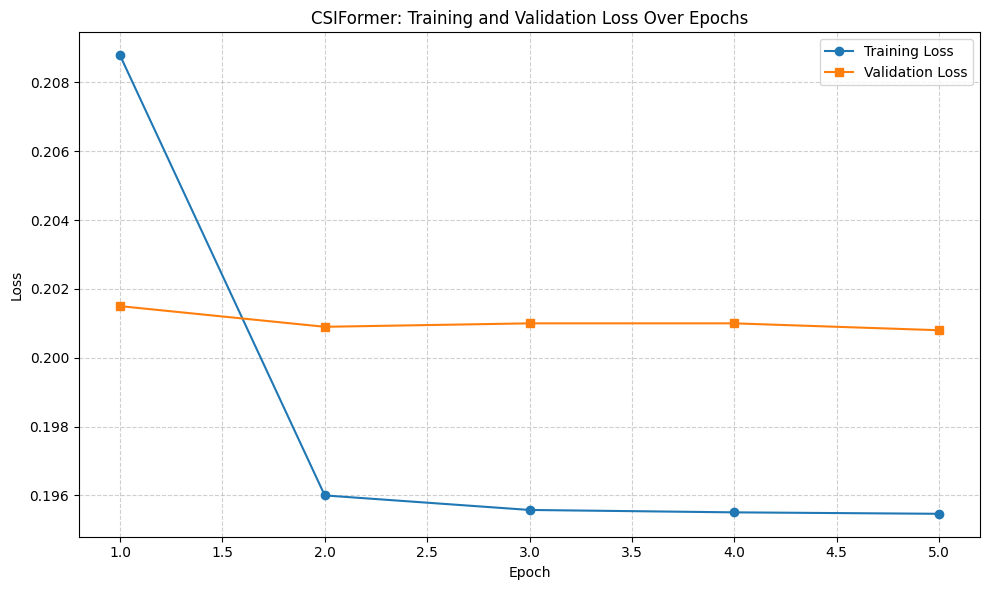

In [4]:
import matplotlib.pyplot as plt
# Extracting epoch loss and validation loss for plotting
train_losses = [
    0.20878794131540426, 0.1960014683362917, 0.19557926443518045, 
    0.19550964507189664, 0.19546766528875445
]
val_losses = [0.2015, 0.2009, 0.2010, 0.2010, 0.2008]

epochs = list(range(1, 6))

# Plotting training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, marker='o', label='Training Loss')
plt.plot(epochs, val_losses, marker='s', label='Validation Loss')

plt.title('CSIFormer: Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()
